# 2D Recurrent Neural Network Position Model

### Load Data

In [20]:
NUM_ITERS = 10000

NUM_CLASSES = 4
NUM_HIDDEN = 30
ROLLOUT = 150
LEARNING_RATE = 0.005
REGULARIZER = 0.001

### Load Data

In [21]:
%store -r rnn_shots

df = rnn_shots['df']
df.label = (df.label == 1) | (df.label == 2) | (df.label == 3)
sideways = df.T

X, Y = np.array(sideways.ix[['x0', 'y0', 'dx0', 'dy0']]).astype(float), np.array(sideways.ix['label']).astype(int)

df.groupby('label').size()

label
False    1619
True     1202
dtype: int64

### Data

/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  app.launch_new_instance()
/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


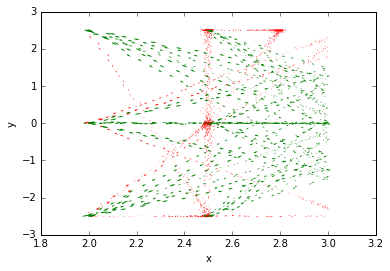

In [22]:
colormap = np.array(['r', 'g', 'b', 'y'])
labels = df['label']
axes = df.plot(kind='scatter', x='x', y='y', c=colormap[labels], s=0)
axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[labels], scale_units='xy', angles='xy', scale=2.5, headwidth=2)

### Train

In [11]:
from rnn.model import RecurrentNeuralNetwork

sideways = df.T

X, Y = np.array(sideways.ix[['x', 'y', 'dx', 'dy']]).astype(float), np.array(sideways.ix['label']).astype(int)

rnn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, rollout=ROLLOUT, learning_rate=LEARNING_RATE, regularizer=REGULARIZER, gradient_checking=False, inspect=True)

def states(iters):
    for i in range(iters):
        if not i % 100:
            print('{}%...'.format((i/NUM_ITERS)*100, end=''))
                  
        rnn.learn()
        yield rnn.info
        
states = list(states(NUM_ITERS))

0.0%...
1.0%...
2.0%...
3.0%...
4.0%...
5.0%...
6.0%...
7.000000000000001%...
8.0%...
9.0%...
10.0%...
11.0%...
12.0%...
13.0%...
14.000000000000002%...
15.0%...
16.0%...
17.0%...
18.0%...
19.0%...
20.0%...
21.0%...
22.0%...
23.0%...
24.0%...
25.0%...
26.0%...
27.0%...
28.000000000000004%...
28.999999999999996%...
30.0%...
31.0%...
32.0%...
33.0%...
34.0%...
35.0%...
36.0%...
37.0%...
38.0%...
39.0%...
40.0%...
41.0%...
42.0%...
43.0%...
44.0%...
45.0%...
46.0%...
47.0%...
48.0%...
49.0%...
50.0%...
51.0%...
52.0%...
53.0%...
54.0%...
55.00000000000001%...
56.00000000000001%...
56.99999999999999%...
57.99999999999999%...
59.0%...
60.0%...
61.0%...
62.0%...
63.0%...
64.0%...
65.0%...
66.0%...
67.0%...
68.0%...
69.0%...
70.0%...
71.0%...
72.0%...
73.0%...
74.0%...
75.0%...
76.0%...
77.0%...
78.0%...
79.0%...
80.0%...
81.0%...
82.0%...
83.0%...
84.0%...
85.0%...
86.0%...
87.0%...
88.0%...
89.0%...
90.0%...
91.0%...
92.0%...
93.0%...
94.0%...
95.0%...
96.0%...
97.0%...
98.0%...
99.0%...


### Plot Losses

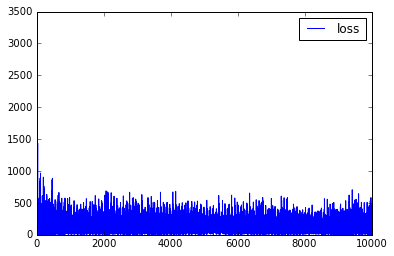

In [12]:
def loss_averages():
    for state in states:
        yield state.loss
        
losses = list(loss_averages())

pd.DataFrame(losses, columns=['loss']).plot()

### Visualize

/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:26: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
/home/ebanner/.anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:27: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


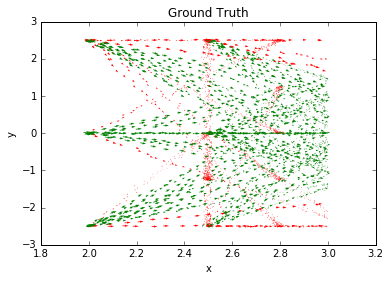

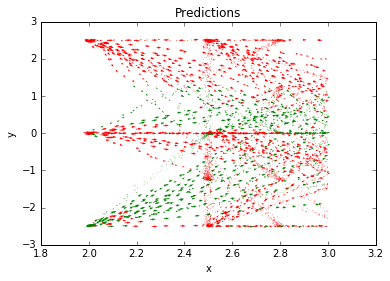

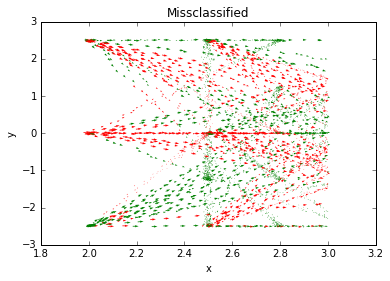

In [13]:
from ipywidgets import interact, fixed

@interact(X=fixed(X), Y=fixed(Y), view_index=(0, len(states)-1), states=fixed(states))
def plot(X, Y, view_index, states):
    """View decision boundary over time
    
    We have the state of the model (i.e. its parameters) after every time step.
    We want to see how the model learns over time. Hence create a one-off instance
    of a softmax with its old parameters and ask it to make a bunch of predictions!
    """
    s = states[view_index]
    rnn = RecurrentNeuralNetwork(X, Y, H=NUM_HIDDEN, C=NUM_CLASSES, Whh=s.Whh, bhh=s.bhh, Wxh=s.Wxh, bxh=s.bxh, Ws=s.Ws, bs=s.bs)

    # Plot the gold standard in a plot right next to it
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['label']], title='Ground Truth', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['label']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Predictions
    scores, predictions = rnn.predict(X)
    df['predictions'] = predictions
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['predictions']], title='Predictions', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['predictions']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

    # Misclassified examples
    df['correct'] = df['label'] == df['predictions']
    axes = df.plot(kind='scatter', x='x', y='y', c=colormap[df['correct']], title='Missclassified', s=0)
    axes.quiver(df['x'], df['y'], df['dx'], df['dy'], color=colormap[df['correct']], scale_units='xy', angles='xy', scale=2.5, width=.0022)

### Raw Accuracy

In [14]:
df['correct'].sum().astype(float) / len(df)

0.61022138483278376

### Shot Accuracy

In [15]:
df['predict_shot'] = (df.predictions == 1) | (df.predictions == 2) | (df.predictions == 3)
df['label_shot'] = (df.label == 1) | (df.label == 2) | (df.label == 3)
df['correct_shot'] = df.predict_shot == df.label_shot

df['correct_shot'].sum().astype(float) / len(df)

0.61022138483278376

### Serialize Model

In [16]:
s = states[-1]

final_state = {'X': X[:,:1], 'ys_train':Y[:1],
               'H': NUM_HIDDEN, 'C': NUM_CLASSES,
               'Whh': s.Whh, 'bhh': s.bhh, 'Wxh': s.Wxh, 'bxh': s.bxh, 'Ws': s.Ws, 'bs': s.bs}

%store final_state

Stored 'final_state' (dict)


### For `python 2.7`

In [22]:
%store -r final_state

In [23]:
import pickle

from rnn.model import RecurrentNeuralNetwork

rnn = RecurrentNeuralNetwork(**final_state)

model = {'clf': rnn, 'features': 'position+velocity', 'window_size': None}

with open('/home/ebanner/nao/trunk/core/python/behaviors/position_velocity-rnn.py', 'wb') as f:
    pickle.dump(model, f)
    
with open('/home/ebanner/nao/trunk/core/python/behaviors/model.py', 'wb') as f:
    pickle.dump(model, f)